In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, hour, dayofweek, avg, count, round, expr

In [3]:
# === Step 1: Initialize Spark ===
spark = SparkSession.builder \
    .appName("NYC Taxi Data Analysis") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/19 04:56:09 WARN Utils: Your hostname, codespaces-b6aaac, resolves to a loopback address: 127.0.0.1; using 10.0.1.115 instead (on interface eth0)
25/06/19 04:56:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/19 04:56:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# === Step 2: Load Data ===
file_path = "yellow_tripdata_2022-01.parquet"
df = spark.read.parquet(file_path)
df.printSchema()
df.show(5)

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+----

In [ ]:
# === Step 3: Clean Data ===
df = df.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime"))
df = df.withColumn("tpep_dropoff_datetime", to_timestamp("tpep_dropoff_datetime"))

# Remove invalid rows (e.g., zero or negative fare or distance)
df = df.filter((col("fare_amount") > 0) & (col("trip_distance") > 0))
df = df.filter((col("passenger_count") > 0))

In [28]:
# === Step 4: Feature Engineering ===
df = df.withColumn("hour", hour("tpep_pickup_datetime"))
df = df.withColumn("day_of_week", dayofweek("tpep_pickup_datetime"))
df = df.withColumn("tip_percent", round(col("tip_amount") / col("fare_amount") * 100, 2))

In [29]:
# === Step 5: Descriptive Analytics ===
# Trip volume by hour of day
hourly_trips = df.groupBy("hour").count()
print("Trip Volume by Hour:")
hourly_trips.orderBy("hour").show()

Trip Volume by Hour:


+----+------+
|hour| count|
+----+------+
|   0| 55237|
|   1| 38637|
|   2| 26448|
|   3| 17447|
|   4| 11153|
|   5| 12757|
|   6| 32658|
|   7| 67506|
|   8| 93646|
|   9|102329|
|  10|112437|
|  11|121575|
|  12|133393|
|  13|138793|
|  14|154124|
|  15|163948|
|  16|158309|
|  17|165998|
|  18|166385|
|  19|142177|
+----+------+
only showing top 20 rows


In [30]:
# Tip percentage by passenger count
tip_by_passenger = df.groupBy("passenger_count").agg(round(avg("tip_percent"), 2).alias("avg_tip_percent"))
print("Average Tip Percent by Passenger Count:")
tip_by_passenger.orderBy("passenger_count").show()

Average Tip Percent by Passenger Count:


+---------------+---------------+
|passenger_count|avg_tip_percent|
+---------------+---------------+
|            1.0|          21.82|
|            2.0|          21.68|
|            3.0|          20.49|
|            4.0|          19.85|
|            5.0|          21.78|
|            6.0|           21.3|
|            7.0|          15.47|
|            8.0|            0.0|
|            9.0|            0.0|
+---------------+---------------+



In [31]:
# Trip count by day of week
trips_by_day = df.groupBy("day_of_week").agg(count("*" ).alias("num_trips"))
print("Trip Volume by Day of Week:")
trips_by_day.orderBy("day_of_week").show()

Trip Volume by Day of Week:


+-----------+---------+
|day_of_week|num_trips|
+-----------+---------+
|          1|   319234|
|          2|   349301|
|          3|   304610|
|          4|   317769|
|          5|   333808|
|          6|   337682|
|          7|   339526|
+-----------+---------+



<Axes: title={'center': 'Trip Volume by Hour'}, xlabel='hour'>

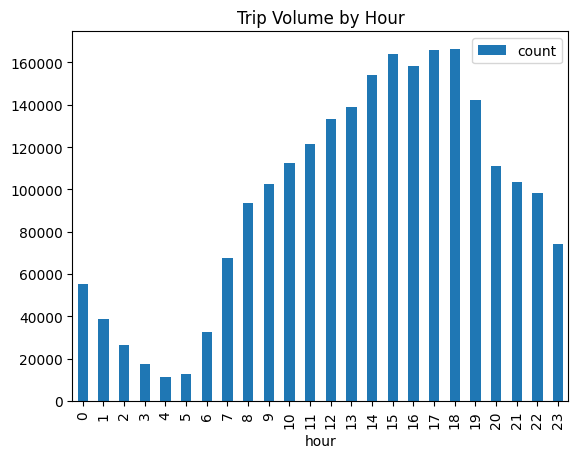

In [32]:
# === Step 6: Export Sample for Plotting ===
hourly_trips_pd = hourly_trips.toPandas()
hourly_trips_pd = hourly_trips_pd.sort_values('hour')
hourly_trips_pd.plot(x="hour", y="count", kind="bar", title="Trip Volume by Hour")

<Axes: title={'center': 'Tip Percentage by Passenger Count'}, xlabel='passenger_count'>

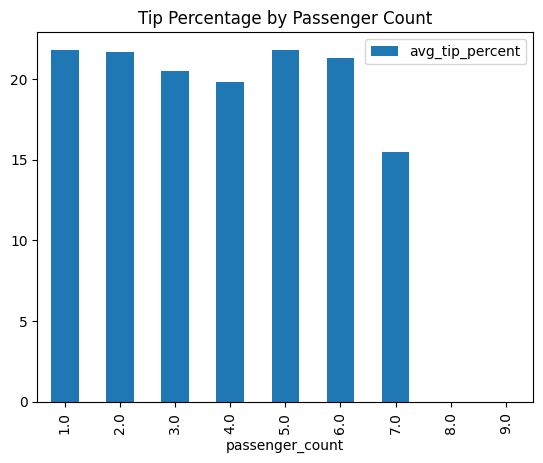

In [33]:
tip_by_passenger_pd = tip_by_passenger.toPandas()
tip_by_passenger_pd = tip_by_passenger_pd.sort_values('passenger_count')
tip_by_passenger_pd.plot(x="passenger_count", y="avg_tip_percent", kind="bar", title="Tip Percentage by Passenger Count")

<Axes: title={'center': 'Trip Volume by Day of Week'}, xlabel='day_of_week'>

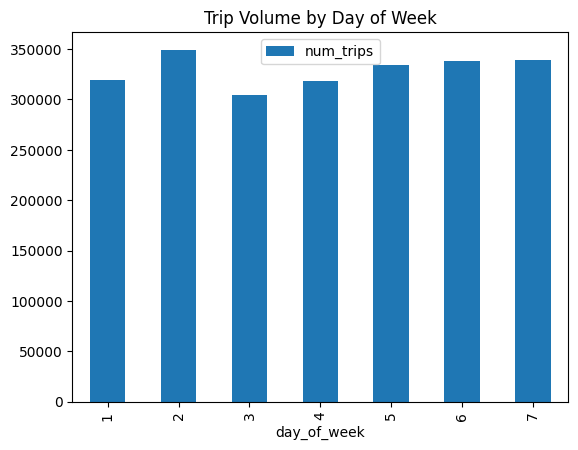

In [36]:
trips_by_day_pd = trips_by_day.toPandas()
trips_by_day_pd = trips_by_day_pd.sort_values('day_of_week')
trips_by_day_pd.plot(x="day_of_week", y="num_trips", kind="bar", title="Trip Volume by Day of Week")